## 【問題1】K-meansクラスの作成
非階層クラスタリングの手法であるK-meansのクラスを作成してください。名前はScratchKMeansとしてください。

教師なし学習であるクラスタリングになるため、ここまでの回帰や分類とは異なるパイプラインを作成することになります。

メソッドやパラメータなどはscikit-learnを参考にしてください。

sklearn.cluster.KMeans — scikit-learn 0.20.0 documentation

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しました。スクラッチの過程で利用してください。

このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。

SSE (Sum of squared errors)は以下で表される。
$$
SSE = \sum_{n=1}^{N}\sum_{k=1}^{K}r_{nk}||X_{n}-\mu_{k}||^{2}
$$

$n$: index of data samples<br>
$k$: index of clusters<br>
$X_{n}$: data of n-th sample<br>
$\mu_{k}$: central point of cluster k<br>
$r_{nk}$: 1 if $X_{n}$ belongs to cluster $k$, else 0<br>


In [1]:
#テストデータ読み込み
import numpy as np
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [2]:
X[:10]

array([[ 0.72086751,  3.71347124],
       [-1.89468423,  7.96898545],
       [ 1.35678894,  4.36462484],
       [ 1.05374379,  4.49286859],
       [ 1.59141542,  4.90497725],
       [ 0.78260667,  4.15263595],
       [-1.95751686,  3.87291474],
       [-0.77354537,  7.87923564],
       [ 0.12313498,  5.27917503],
       [-1.43284669,  7.71577043]])

In [3]:
#dataを見てみる
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = plt.scatter(X[:, 0], X[:, 1])

#4個っぽいのでn_neighbors = 4 としてみる
plt.show()

<Figure size 400x400 with 1 Axes>

In [4]:
#具体例でイメージの把握をする。
#muを初期化
#cluster数 = 5で
n_clusters = 5

mu_idx = np.array([np.random.randint(0,X.shape[0]) for i in range(5)])
print(mu_idx)

mu = X[mu_idx] 
print(mu)

[22 42 41  1 61]
[[-1.91186205  3.18750686]
 [-1.57006498  6.72375844]
 [-1.44356727  3.23539798]
 [-1.89468423  7.96898545]
 [ 1.51989121  1.42488952]]


In [5]:
v0 = X-mu[0, :]
v1 = X-mu[1, :]
v2 = X-mu[2, :]
v3 = X-mu[3, :]
v4 = X-mu[4, :]
print(v0.shape)
print(v0[:10])

(100, 2)
[[ 2.63272956  0.52596438]
 [ 0.01717782  4.78147859]
 [ 3.26865099  1.17711798]
 [ 2.96560584  1.30536173]
 [ 3.50327747  1.71747039]
 [ 2.69446872  0.9651291 ]
 [-0.04565481  0.68540788]
 [ 1.13831668  4.69172878]
 [ 2.03499703  2.09166817]
 [ 0.47901536  4.52826357]]


In [6]:
import math
#各点X_nからmu_kまでの距離d
d0 = v0*v0
d1 = v1*v1
d2 = v2*v2
d3 = v3*v3
d4 = v4*v4

d0 = ((d0[:, 0] + d0[:, 1])**(1/2)).reshape(-1, 1)
d1 = ((d1[:, 0] + d1[:, 1])**(1/2)).reshape(-1, 1)
d2 = ((d2[:, 0] + d2[:, 1])**(1/2)).reshape(-1, 1)
d3 = ((d3[:, 0] + d3[:, 1])**(1/2)).reshape(-1, 1)
d4 = ((d4[:, 0] + d4[:, 1])**(1/2)).reshape(-1, 1)

d = d0
d = np.concatenate([d, d1], axis=1)
d = np.concatenate([d, d2], axis=1)
d = np.concatenate([d, d3], axis=1)
d = np.concatenate([d, d4], axis=1)
d[:10]

array([[2.68475389, 3.78288259, 2.21660369, 4.99504876, 2.42405551],
       [4.78150945, 1.28684419, 4.7550349 , 0.        , 7.38136281],
       [3.47414537, 3.75925328, 3.01946157, 4.85422427, 2.94425645],
       [3.24018321, 3.44401539, 2.79603198, 4.55813737, 3.10319013],
       [3.90162243, 3.64731727, 3.46390168, 4.64123227, 3.48082265],
       [2.8621034 , 3.48507313, 2.40773252, 4.6618033 , 2.82563074],
       [0.68692672, 2.8770521 , 0.81888448, 4.0965526 , 4.25266908],
       [4.82784463, 1.40341406, 4.69192471, 1.12472546, 6.84970329],
       [2.91826809, 2.22570154, 2.57518554, 3.36253989, 4.0995664 ],
       [4.55352903, 1.00145726, 4.48038527, 0.52669893, 6.94937721]])

In [7]:
#各点X_nに対して、最も近いmu_kのindex k
min_idx = d.argmin(1)
min_idx

array([2, 3, 4, 2, 2, 2, 0, 3, 1, 3, 1, 1, 1, 3, 1, 4, 4, 2, 0, 4, 4, 3,
       0, 4, 2, 2, 2, 2, 4, 4, 4, 1, 4, 4, 2, 4, 3, 4, 3, 0, 2, 2, 1, 0,
       0, 3, 4, 0, 2, 2, 2, 4, 2, 0, 2, 1, 3, 4, 4, 3, 1, 4, 4, 4, 4, 3,
       0, 2, 4, 2, 3, 4, 2, 3, 2, 4, 2, 2, 4, 4, 4, 3, 2, 2, 4, 2, 4, 4,
       4, 2, 2, 2, 2, 2, 0, 3, 3, 2, 3, 2])

In [8]:
#mu更新
for i in range(n_clusters):
        print([np.array(X[min_idx == i]).mean(axis=0)])
        mu[i, :] = np.array(X[min_idx == i]).mean(axis=0)
        print(mu)
        print(X[min_idx == i].shape)

[array([-1.95369321,  3.17416186])]
[[-1.95369321  3.17416186]
 [-1.57006498  6.72375844]
 [-1.44356727  3.23539798]
 [-1.89468423  7.96898545]
 [ 1.51989121  1.42488952]]
(10, 2)
[array([-1.09250364,  6.94480117])]
[[-1.95369321  3.17416186]
 [-1.09250364  6.94480117]
 [-1.44356727  3.23539798]
 [-1.89468423  7.96898545]
 [ 1.51989121  1.42488952]]
(9, 2)
[array([-0.1182033 ,  3.75869787])]
[[-1.95369321  3.17416186]
 [-1.09250364  6.94480117]
 [-0.1182033   3.75869787]
 [-1.89468423  7.96898545]
 [ 1.51989121  1.42488952]]
(33, 2)
[array([-1.27925091,  8.0512077 ])]
[[-1.95369321  3.17416186]
 [-1.09250364  6.94480117]
 [-0.1182033   3.75869787]
 [-1.27925091  8.0512077 ]
 [ 1.51989121  1.42488952]]
(17, 2)
[array([1.91199753, 1.58485859])]
[[-1.95369321  3.17416186]
 [-1.09250364  6.94480117]
 [-0.1182033   3.75869787]
 [-1.27925091  8.0512077 ]
 [ 1.91199753  1.58485859]]
(31, 2)


イメージつかめたのでクラス作成<br>
[pyファイル](https://github.com/ohmorimori/diveintocode-ml/blob/master/diveintocode-term1/ml-scratch/model/scratch_k_means.py)

In [9]:
import sys

dir_str = "../../ml-scratch/model"
if dir_str not in sys.path:
        sys.path.append(dir_str)
from scratch_k_means import ScratchKMeans

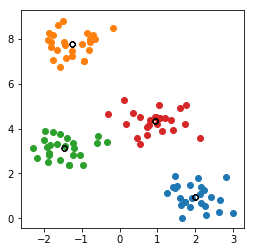

array([3, 1, 3, 3, 3, 3, 2, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 0, 3, 1,
       2, 0, 3, 2, 2, 3, 0, 0, 0, 1, 0, 0, 2, 3, 1, 0, 1, 2, 3, 2, 1, 2,
       2, 1, 0, 2, 3, 3, 3, 0, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 3, 0, 1,
       2, 2, 0, 3, 1, 0, 3, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 3, 0, 2, 0, 0,
       3, 3, 3, 2, 3, 2, 2, 1, 1, 2, 1, 3])

In [12]:

km = ScratchKMeans(n_clusters=4)
km.fit(X)
cluster, distance, sse = km.predict(X)
km.plot_result(X, cluster)
cluster

## 【問題2】エルボー法の実装
K-meansにおいて中心点の個数 
k
 は人為的に決める必要があるが、その判断方法としてエルボー法があります。

SSEを縦軸、クラスタ数 
k
 を横軸にした折れ線グラフを表示します。

このためにK-meansのインスタンスからはSSEを取得できるようにしてください。


In [13]:
n = 30
sse = np.empty((n, 1))
for i in range(1, n):
        km = ScratchKMeans(n_clusters=i)
        km.fit(X)
        clst, d, sse[i] = km.predict(X)
sse

array([[ -1.        ],
       [870.26117979],
       [351.48372865],
       [139.17097772],
       [ 48.63378321],
       [ 44.88223785],
       [ 39.55192471],
       [ 36.25559082],
       [ 34.99499467],
       [ 32.53930411],
       [ 27.41770706],
       [ 21.91658186],
       [ 22.37909692],
       [ 18.28117891],
       [ 18.58730362],
       [ 19.58472249],
       [ 17.48716692],
       [ 14.94611184],
       [ 13.31286025],
       [ 13.77579431],
       [ 11.71117487],
       [ 10.17281662],
       [  9.9037403 ],
       [ 10.6351091 ],
       [  8.68304096],
       [  8.16204878],
       [  8.25248802],
       [ 10.72112748],
       [  8.1590148 ],
       [  8.19857748]])

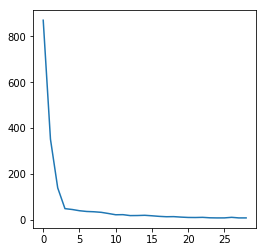

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = plt.plot(sse[1:], label=i)
plt.show()

## 【問題3】（アドバンス課題）シルエット図
この数式を実装し、シルエット図を確認してください。
$$
s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$$
$a_{n}$: 凝集度。同じクラスタ内の他のデータ点との距離の平均値<br>
$b_{n}$: 乖離度。最も近いクラスタ内の全てのデータ点との距離の平均値<br>


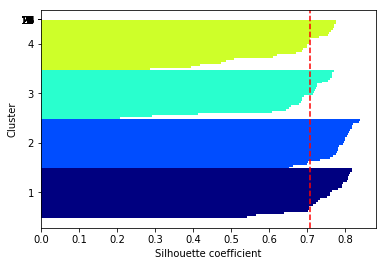

In [15]:
#シルエット図を表示するためのコード
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(clst)
#シルエット係数
silhouette_vals = silhouette_samples(X,cluster,metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[cluster == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

## 【問題4】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

エルボー法より、SSEの低下が鈍くなる3 or 4個のクラスター数が適当と思われる。
2変数の場合散布図のグラフの見た目から４つ程度と判断でき、エルボー法やシルエット図からもその妥当性が裏付けられたと言える。
次元が増えて目視判断できない場合にもエルボー法やシルエット図は有効と思われる。


## 【問題5】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [16]:
#read data
import pandas as pd
df = pd.read_csv("/Users/ohmori/diveintocode-ml/diveintocode-term1/sprint/sprint7/Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [17]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


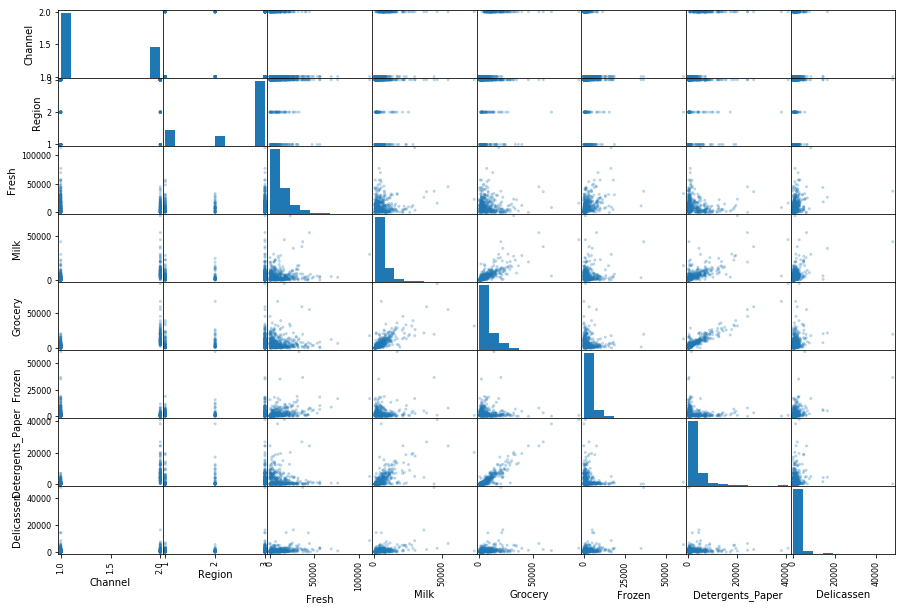

In [18]:
#分布を確認
pd.plotting.scatter_matrix(df, alpha=0.3, figsize=(15, 10));

In [19]:
#categoricalとcontinuousに分ける
a = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
b = ['Region', 'Channel']
df_a = df.loc[:, a]
df_a[:10]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
7,7579,4956,9426,1669,3321,2566
8,5963,3648,6192,425,1716,750
9,6006,11093,18881,1159,7425,2098


In [20]:
df_b = df.loc[:, b]
df_b[:10]

,Region,Channel
0,3,2
1,3,2
2,3,2
3,3,1
4,3,2
5,3,2
6,3,2
7,3,2
8,3,1
9,3,2


In [21]:
#分布偏っているのでlogをとる
df_a_log = np.log10(df_a)

In [22]:
df_log = pd.concat([df_a_log, df_b], axis=1)
df_log.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,Channel
0,4.102742,3.984797,3.878579,2.330414,3.427161,3.126456,3,2
1,3.848620,3.991669,3.980821,3.246006,3.517592,3.249443,3,2
2,3.802979,3.944877,3.885587,3.381115,3.546049,3.894538,3,2
3,4.122707,3.077731,3.625415,3.806451,2.705008,3.252368,3,1
4,4.354397,3.733197,3.857212,3.592732,3.249687,3.714749,3,2


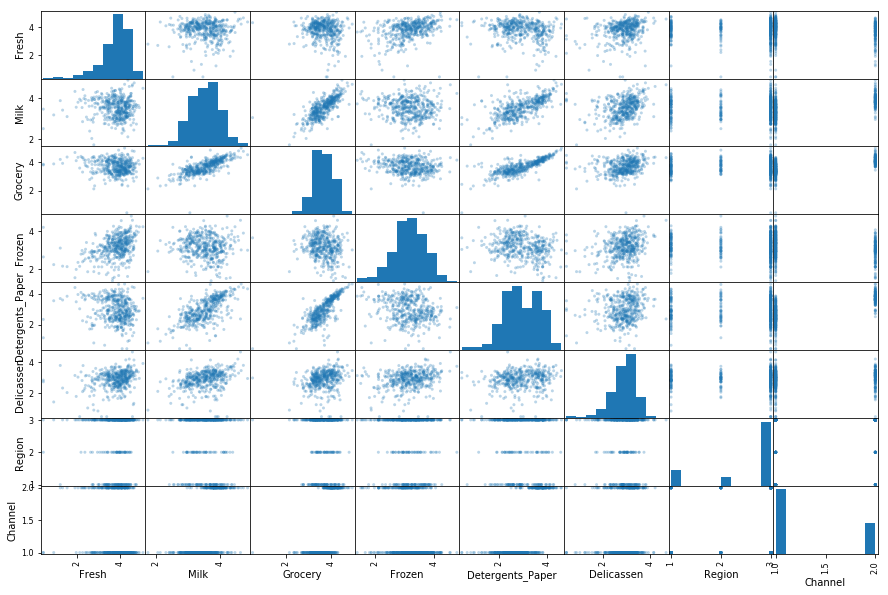

In [23]:
#分布を確認
pd.plotting.scatter_matrix(df_log, alpha=0.3, figsize=(15, 10));

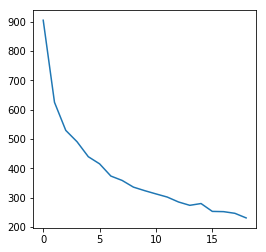

In [25]:
#エルボー法でk-meansのクラスター数見積もり
#~4くらい?
n = 20
sse = np.empty((n, 1))
for i in range(1, n):
        clf = ScratchKMeans(n_clusters=i)
        clf.fit(df_a_log)
        cluster, distance, sse[i] = clf.predict(df_a_log)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = plt.plot(sse[1:], label=i)
plt.show()

[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


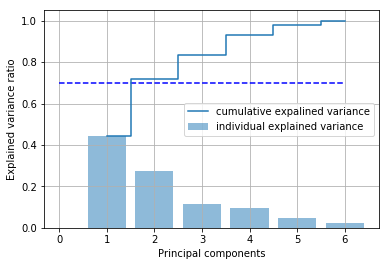

In [26]:
#PCAの分散説明率を表示
#2個あれば良さそう
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(df_a_log)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [27]:
#PCAで次元削減
pca = PCA(n_components = 2)
pca = pca.fit(df_a_log)
pca_df_a_log = pca.transform(df_a_log)
print(pca_df_a_log[:10])


[[-0.76044326 -0.03062437]
 [-0.78188873 -0.37772918]
 [-0.82243908 -0.72814713]
 [ 0.4895858  -0.63319366]
 [-0.34600739 -1.06874039]
 [-0.47069865 -0.17065273]
 [-0.49188628  0.08755458]
 [-0.68725963 -0.42048236]
 [-0.37862888  0.2591691 ]
 [-1.25462601 -0.32185674]]


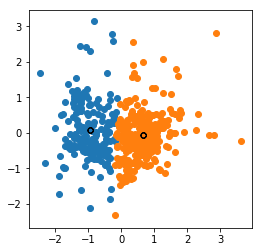

In [28]:
a = np.array(pca_df_a_log)
clf = ScratchKMeans(n_clusters=2)
clf.fit(a)
cluster, distance, sse = clf.predict(a)
clf.plot_result(a, cluster)

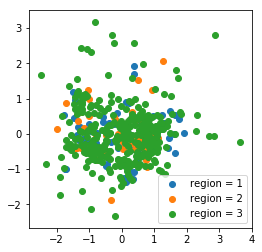

In [30]:
#Regionで色分け
A = np.concatenate((pca_df_a_log, np.array(df_b)), axis=1)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = plt.scatter(A[A[:, 2] == 1, 0], A[A[:, 2] == 1, 1], label='region = 1')
ax = plt.scatter(A[A[:, 2] == 2, 0], A[A[:, 2] == 2, 1], label='region = 2')
ax = plt.scatter(A[A[:, 2] == 3, 0], A[A[:, 2] == 3, 1], label='region = 3')
plt.legend()
plt.show()

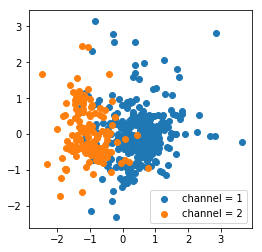

In [31]:
#Channelで色分け
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = plt.scatter(A[A[:, 3] == 1, 0], A[A[:, 3] == 1, 1], label='channel = 1')
ax = plt.scatter(A[A[:, 3] == 2, 0], A[A[:, 3] == 2, 1], label='channel = 2')
plt.legend()
plt.show()

ChannelがPCAで次元を2つに減らした際のクラスタリングの分類結果とうまく一致しそうなことがわかった。

## 【問題6】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

ヒント

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。

条件ごとにデータを見る際にはPandasのgroupbyが便利です。

pandas.DataFrame.groupby — pandas 0.23.4 documentation

In [38]:
new_df = pd.concat([df_a_log, df_b], axis=1)
new_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,Channel
0,4.102742,3.984797,3.878579,2.330414,3.427161,3.126456,3,2
1,3.848620,3.991669,3.980821,3.246006,3.517592,3.249443,3,2
2,3.802979,3.944877,3.885587,3.381115,3.546049,3.894538,3,2
3,4.122707,3.077731,3.625415,3.806451,2.705008,3.252368,3,1
4,4.354397,3.733197,3.857212,3.592732,3.249687,3.714749,3,2


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

new_df_corr = new_df.corr()
new_df_corr

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,Channel
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186,0.013433,-0.168050
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833,0.034195,0.577156
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728,0.001466,0.660635
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718,-0.085397,-0.244961
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735,0.014386,0.724456
Delicassen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000,-0.012041,0.130466
Region,0.013433,0.034195,0.001466,-0.085397,0.014386,-0.012041,1.000000,0.062028
Channel,-0.168050,0.577156,0.660635,-0.244961,0.724456,0.130466,0.062028,1.000000


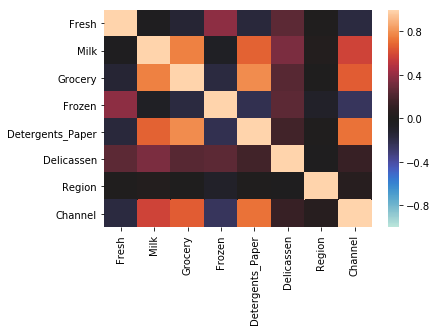

In [40]:
#相関見る
sns.heatmap(new_df_corr, vmax=1, vmin=-1, center=0)

In [41]:
abs(new_df_corr.loc['Milk']).sort_values(ascending=False)

Milk                1.000000
Grocery             0.758851
Detergents_Paper    0.677942
Channel             0.577156
Delicassen          0.337833
Frozen              0.055316
Region              0.034195
Fresh               0.019834
Name: Milk, dtype: float64

In [42]:
clf = ScratchKMeans(n_clusters=2)
clf.fit(np.array(new_df))
cluster, distance, sse = clf.predict(np.array(new_df))

#クラスターの情報を付与
new_df['Cluster'] = cluster
new_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,Channel,Cluster
0,4.102742,3.984797,3.878579,2.330414,3.427161,3.126456,3,2,0
1,3.848620,3.991669,3.980821,3.246006,3.517592,3.249443,3,2,0
2,3.802979,3.944877,3.885587,3.381115,3.546049,3.894538,3,2,0
3,4.122707,3.077731,3.625415,3.806451,2.705008,3.252368,3,1,0
4,4.354397,3.733197,3.857212,3.592732,3.249687,3.714749,3,2,0


In [43]:
#各クラスタに分類されたサンプルの数
new_df[['Fresh', 'Cluster']].groupby(['Cluster']).count()

,Fresh
Cluster,
0,334
1,106


In [56]:
#クラスタ別の購買力
clustering = new_df.drop(['Region', 'Channel'], axis=1).groupby(['Cluster']).mean()
count = np.array(new_df[['Cluster', 'Region']].groupby(['Cluster']).count())
clustering['Count'] = count
clustering

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Count
Cluster,,,,,,,
0,3.790004,3.558182,3.684117,3.129218,2.995302,2.889093,334
1,3.796740,3.428438,3.608719,3.302469,2.795259,2.912078,106


 洗剤、紙（Detergents, Paper）に関してCluster 0は年間消費額がCluster1よりも10^0.2 = 1.5倍程度大きいことがわかった。


In [62]:
#regionとchannelの観点からDetergents, paperをみる
#cluster 0
#Channel2の購買力が高い
new_df[new_df['Cluster'] == 0][['Channel', 'Region', 'Detergents_Paper']].groupby(['Channel', 'Region']).mean()

Detergents_Paper
Channel Region                  
1       3               2.565969
2       2               3.832345
        3               3.714564

In [64]:
#cluster 1
#Channel2かつRegion1の購買力が高い
new_df[new_df['Cluster'] == 1][['Channel', 'Region', 'Detergents_Paper']].groupby(['Channel', 'Region']).mean()

Detergents_Paper
Channel Region                  
1       1               2.630800
        2               2.512206
2       1               3.789853
        2               2.521138

In [65]:
#Region別の購買力を見てみる

#各商材に関して特別差はない
new_df.groupby(['Region']).mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel,Cluster
Region,,,,,,,,
1,3.797705,3.507541,3.629690,3.258611,2.901748,2.912156,1.233766,1.000000
2,3.709267,3.474301,3.779632,3.228281,3.017981,2.886783,1.404255,0.617021
3,3.802396,3.539477,3.657881,3.141071,2.947623,2.891527,1.332278,0.000000


In [60]:
#Channel別の購買力
#Detergents, paperも含めて各商材の購買力がChannelによって異なる（10^0.2程度以上は違う)。
#FreshやFrozenはChannel 0の方が売れる
new_df.groupby(['Channel']).mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,Cluster
Channel,,,,,,,,
1,3.866108,3.340033,3.445143,3.265182,2.573753,2.843419,2.510067,0.291946
2,3.635321,3.919137,4.129343,2.973214,3.730634,3.002103,2.612676,0.133803


Clusteringによる分類で差が出ている商材を元に、情報を分析しchannelの観点から各商材で売り上げが違うことがわかった。Channel毎に販売の戦略を変えていくことができると考えられる。

## 【問題7】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。

DBSCANのメリット・デメリット
t-SNE、LLEのメリット・デメリット
について記述してください。

DBSCAN
* メリット：
    * 事前にデータのクラスタ数を指定しなくて良い
    * クラスタを、その形状に左右されずに見つけることができる（K-meansだと、例えば同心円上に広がる２つの半径の異なるリングの集合◎は区別できない）
    * ノイズ（外れ値）に対して強い

* デメリット: 
    * 密度に大きな違いがあるクラスタを分類できない
    * 次元が大きくなると、収束しにくい
t-SNE
* メリット:
    * 高次元空間の点の集合から、２次元などの低次元空間で可視化するのに優れている（他の可視化よりもわかりやすく人間の直感に近い図示がされる場合が多い）
* デメリット:
    * 計算コストが高い
LLE
* メリット:
    * 非線形の成分を含んだデータの次元削減に使える（PCAは使えない）
* デメリット:
    * パラメータとして選ぶ近傍点の数次第で、局所的な特徴を捉えているが全域的な特徴が抜け落ちるなどが起こりうる。

## 【問題8】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。

そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。

sklearn.manifold.TSNE — scikit-learn 0.20.2 documentation

sklearn.cluster.DBSCAN — scikit-learn 0.20.2 documentation

パラメーターチューニング

これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

t-SNEの論文

DBSCANの論文

5.ディスカッション

## 【問題9】教師なし学習と教師あり学習
最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

教師なし学習は教師あり学習とどのような違いがあるか